In [30]:
import os
import glob
import json
from typing import Tuple, List
from datetime import datetime, timedelta
import pickle
import shutil
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm

from utils.data_transform import Sentinel2Transform
from utils.sentinel_2_reader import S2Reader
from utils.data_loader import DataLoader

In [2]:
from radiant_mlhub import Dataset

os.environ['MLHUB_API_KEY'] = '380ab1acf08f82cddc417ddaf61b6acbaceb0e6a125435e63b79d93efe0110c6'

if not os.path.exists('data/'):
    os.makedirs('data/')

In [3]:
dataset = Dataset.fetch('dlr_fusion_competition_germany')
print(f'{dataset.id}: {dataset.title}')
dataset.download('data/')

dlr_fusion_competition_germany: A Fusion Dataset for Crop Type Classification in Germany


INFO:radiant_mlhub.client.catalog_downloader:unarchive dlr_fusion_competition_germany.tar.gz ...
unarchive dlr_fusion_competition_germany.tar.gz: 100%|██████████| 1790/1790 [00:00<00:00, 18189.67it/s]
INFO:radiant_mlhub.client.catalog_downloader:create stac asset list (please wait) ...
INFO:radiant_mlhub.client.catalog_downloader:1654 unique assets in stac catalog.
download assets: 100%|██████████| 1654/1654 [00:05<00:00, 293.63it/s]
INFO:radiant_mlhub.client.catalog_downloader:assets saved to data\dlr_fusion_competition_germany


In [4]:
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'
brandenburg_te_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_test_labels/dlr_fusion_competition_germany_test_labels_33N_17E_243N/vector_labels.geojson'

In [5]:
brandenburg_tr_labels=gpd.read_file(brandenburg_tr_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(brandenburg_tr_labels)))
brandenburg_tr_labels.info()
brandenburg_tr_labels.tail()

INFO: Number of fields: 2534

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         2534 non-null   int64   
 1   SHAPE_AREA  2534 non-null   float64 
 2   SHAPE_LEN   2534 non-null   float64 
 3   crop_id     2534 non-null   int64   
 4   crop_name   2534 non-null   object  
 5   geometry    2534 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 118.9+ KB


,fid,SHAPE_AREA,SHAPE_LEN,crop_id,crop_name,geometry
2529,210145,259644.80075,2922.908013,5,Corn,"MULTIPOLYGON (((451162.920 5809950.180, 451386..."
2530,210149,11260.80940,433.843678,2,Rye,"MULTIPOLYGON (((452645.460 5809120.610, 452645..."
2531,210174,593211.62605,3766.251880,5,Corn,"MULTIPOLYGON (((451948.160 5827166.390, 451948..."
2532,210179,48034.13890,1210.785843,9,Forage Crops,"MULTIPOLYGON (((439830.770 5808003.000, 439881..."
2533,210180,428209.99690,3885.101917,6,Oil Seeds,"MULTIPOLYGON (((437976.290 5828007.960, 437952..."


In [7]:
label_ids=brandenburg_tr_labels['crop_id'].unique()
label_names=brandenburg_tr_labels['crop_name'].unique()

print('INFO: Label IDs: {}'.format(label_ids))
print('INFO: Label Names: {}'.format(label_names))

INFO: Label IDs: [9 1 8 2 3 5 6 7 4]
INFO: Label Names: ['Forage Crops' 'Wheat' 'Meadows' 'Rye' 'Barley' 'Corn' 'Oil Seeds'
 'Root Crops' 'Oats']


INFO: Number of Fields by Crop Type: 
Meadows         954
Forage Crops    339
Wheat           305
Rye             279
Corn            251
Oil Seeds       201
Barley          137
Oats             45
Root Crops       23
Name: crop_name, dtype: int64


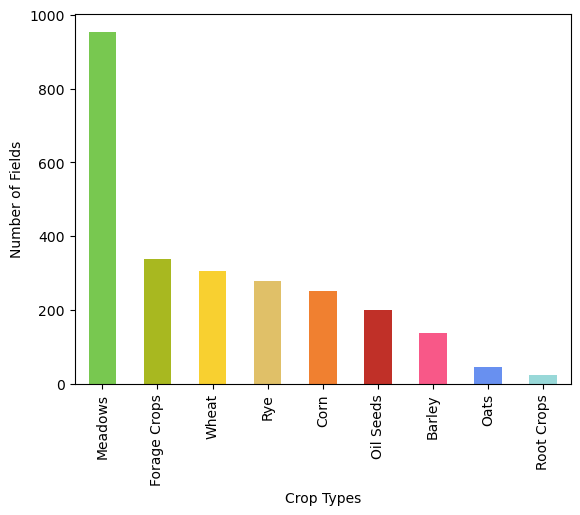

In [8]:
value_counts=brandenburg_tr_labels['crop_name'].value_counts()

colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 
ax=value_counts.plot.bar(color=colors_list)
ax.set_ylabel("Number of Fields")
ax.set_xlabel("Crop Types")

print('INFO: Number of Fields by Crop Type: \n{}'.format(value_counts))

# Working with Sentinel 2 Data

In [9]:
brandenburg_s2_train_dir = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/"
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'

In [15]:
import numpy as np

# Load the .npz file
data = np.load("data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/fid_3935.npz")

# Check the available data indices
available_indices = data['image_stack']
print(len(data['image_stack']))
print("Available data indices:", available_indices)


144
Available data indices: <numpy.lib.npyio.NpzFile object at 0x000001FAC6280B20>


In [11]:
def true_color(X):
    blue = X[1]/(X[1].max()/255.0)
    green = X[2]/(X[2].max()/255.0)
    red = X[3]/(X[3].max()/255.0)
    tc = np.dstack((red,green,blue)) 
    
    return tc.astype('uint8')

def ndvi(X):
    red = X[3]
    nir = X[7]
    return (nir-red) / (nir + red)

In [12]:
s2_reader = S2Reader(input_dir=brandenburg_s2_train_dir, label_dir=brandenburg_tr_labels_dir, selected_time_points=range(143))

crop_id, crop_name = label_ids[7], label_names[0]

INFO: Ignoring 30/2534 fields with area < 1000m2


INFO: Extracting time series into the folder: data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/: 100%|██████████| 2504/2504 [00:00<00:00, 10450.22it/s]


In [13]:
# Print Median value of each field for all days
median = []
days = []
iterable = iter(s2_reader)
while True:
    X, y, mask, _ = next(iterable)

    width = X.shape[-1]
    height = X.shape[-2]

    if y == crop_id and width > 60 and height > 60:
        for day in range(143):
            median.append(np.median(ndvi(X[day])))
            days.append(day)

        break

print(median)
print(days)

[0.0057564145, 0.09944025, 0.20198223, 0.32971156, 0.0015591502, 0.050518528, 0.03803815, 0.022756416, 0.18555291, 0.61271363, 0.056393884, 0.019072672, 0.49665546, 0.039811343, 0.64105225, 0.62569046, 0.10106878, 0.7184569, 0.17580205, -0.007819209, 0.39882195, 0.35544723, 0.296288, 0.26985788, 0.26246506, 0.04496739, -0.01727515, -0.02075155, 0.1409421, -0.013890986, 0.2657952, 0.13920842, 0.0066433633, 0.19727582, 0.039676644, 0.043268766, 0.24955645, 0.2280557, 0.27551597, 0.26213694, 0.09124398, 0.07145836, 0.30614144, 0.24874386, 0.27871943, 0.016980857, 0.27263933, 0.22820637, -0.004578867, 0.27396175, 0.25420076, 0.23443276, 0.084032044, 0.3069678, 0.1456943, 0.40385944, 0.5327801, 0.60770833, 0.69598615, 0.68462837, 0.46684757, 0.8092791, 0.7780479, 0.048081324, 0.06405694, 0.7327143, -0.002546382, 0.020480854, 0.312674, 0.1213839, 0.52285063, 0.75420046, 0.72831523, -0.009167584, 0.03207184, 0.048818097, 0.43634903, 0.7099407, 0.07726663, 0.6731772, 0.7881583, 0.7746533, 0.50

<function matplotlib.pyplot.show(close=None, block=None)>

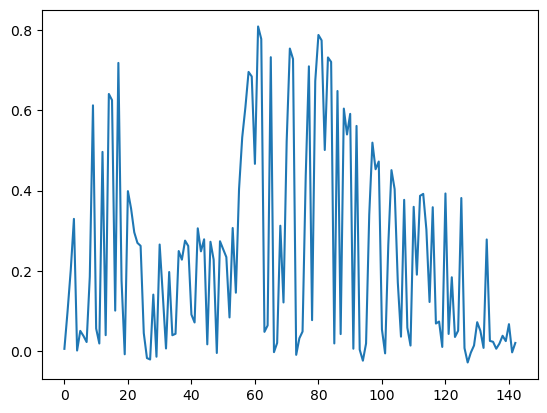

In [14]:
plt.plot(days, median)
plt.show

# Preparing Sentinel 2 data

In [18]:
brandenburg_s2_train_dir = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/"
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'

brandenburg_tr_labels=gpd.read_file(brandenburg_tr_labels_dir)
label_ids=brandenburg_tr_labels['crop_id'].unique()
label_names=brandenburg_tr_labels['crop_name'].unique()

In [21]:
zipped_lists = zip(label_ids, label_names)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
label_ids, label_names = [ list(tuple) for tuple in  tuples]

In [31]:
sentinel_2_transformer=Sentinel2Transform()
s2_reader = S2Reader(input_dir=brandenburg_s2_train_dir, label_dir=brandenburg_tr_labels_dir, label_ids=label_ids, transform=sentinel_2_transformer.transform, min_area_to_ignore=1000)

data_loader=DataLoader(train_val_reader=s2_reader, validation_split=0.25)
train_loader=data_loader.get_train_loader(batch_size=8, num_workers=1)
valid_loader=data_loader.get_validation_loader(batch_size=8, num_workers=1)

INFO: Ignoring 30/2534 fields with area < 1000m2


INFO: Extracting time series into the folder: data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/: 100%|██████████| 2504/2504 [00:00<00:00, 23909.56it/s]


INFO: Training data loader initialized.
INFO: Validation data loader initialized.
